## Contents
1. **Data overview** <br> _We begin this study by conducting an exploratory analysis of the raw dataset using basic descriptive statistics to get a quick sense of the data._
2. **Data Cleaning** <br> _We then proceed to exclude suspicious features and employ a straightforward approach to achieve a balanced target dataset quickly._
3. **Significance tests** <br> _Next, we apply non-parametric statistical tests to assess the significance of features, relying on the large training sample to handle the majority of the work._
4. **Preprocessing** <br> _Subsequently, essential preprocessing steps are implemented to scale and encode the data into a format suitable for neural network._
5. **Deep Learning** <br> _Neural network weights estimation with backpropagation._
6. **Evaluation** <br> _Metrics calculation, visualizing the confusion matrix, and plotting the ROC curve to assess its predictive capability._

# 1) Data overview

In [ ]:
import time
import numpy as np
import pandas as pd

In [2]:
%%time
train = pd.read_csv('/home/petewojtczak/Desktop/auto_insurance_clf/train.csv')
test = pd.read_csv('/home/petewojtczak/Desktop/auto_insurance_clf/test.csv')
train.shape, test.shape, train.isnull().values.any(), test.isnull().values.any(), train.duplicated().sum(), test.duplicated().sum()

CPU times: user 20.3 s, sys: 2.12 s, total: 22.4 s
Wall time: 22.4 s


((11504798, 12), (7669866, 11), False, False, 0, 0)

In [3]:
train.sample(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
1332101,1332101,Male,41,1,28.0,0,1-2 Year,Yes,38702.0,124.0,21,0
2631432,2631432,Male,27,1,26.0,1,< 1 Year,No,2630.0,152.0,153,0
435060,435060,Male,53,1,28.0,0,1-2 Year,Yes,47930.0,26.0,31,0


In [4]:
test.sample(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
2361556,13866354,Male,53,1,28.0,1,1-2 Year,No,47382.0,124.0,75
2157940,13662738,Female,37,1,28.0,0,1-2 Year,Yes,44163.0,29.0,129
5310178,16814976,Male,41,1,28.0,0,1-2 Year,No,37222.0,124.0,99


In [5]:
# imbalanced target variable
train.Response.value_counts(normalize=True)

0    0.877003
1    0.122997
Name: Response, dtype: float64

In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000,11504798.000
mean,5752398.500,38.384,0.998,26.419,0.463,30461.370,112.425,163.898,0.123
std,3321149.255,14.993,0.044,12.992,0.499,16454.745,54.036,79.980,0.328
min,0.000,20.000,0.000,0.000,0.000,2630.000,1.000,10.000,0.000
25%,2876199.250,24.000,1.000,15.000,0.000,25277.000,29.000,99.000,0.000
50%,5752398.500,36.000,1.000,28.000,0.000,31824.000,151.000,166.000,0.000
75%,8628597.750,49.000,1.000,35.000,1.000,39451.000,152.000,232.000,0.000
max,11504797.000,85.000,1.000,52.000,1.000,540165.000,163.000,299.000,1.000


# 2) Data Cleaning

In [7]:
train.set_index('id', inplace=True)

In [8]:
# according to train.describe() 'Driving_License' is invariant
train.drop(columns=['Driving_License'], inplace=True)

In [9]:
feature_info = {
    'feature': [],
    'dtype': [],
    'unique_val': [],
    }

for col in train.columns:
    feature_info['feature'].append(col)
    feature_info['dtype'].append(train[col].dtype)
    feature_info['unique_val'].append(len(train[col].unique()))

# features' metadata dataframe
features = pd.DataFrame(feature_info)
features.set_index('feature', inplace=True)
features = features.sort_values(by='unique_val', ascending=False)
features

,dtype,unique_val
feature,,
Annual_Premium,float64,51728
Vintage,int64,290
Policy_Sales_Channel,float64,152
Age,int64,66
Region_Code,float64,54
Vehicle_Age,object,3
Gender,object,2
Previously_Insured,int64,2
Vehicle_Damage,object,2


In [10]:
# Seems to be nominal; highly problematic due to 54 unique values
train.drop(columns=['Region_Code'], inplace=True)
# Seems to be nominal; highly problematic due to 152 unique values
train.drop(columns=['Policy_Sales_Channel'], inplace=True)
# nominal feature
train.Previously_Insured = train.Previously_Insured.astype(str)

In [11]:
# rebalanced dataset sampling
train_1 = train[train.Response==1]
train_0 = train[train.Response==0].sample(train_1.shape[0], random_state=666)
df_train = pd.concat([train_0, train_1])
df_train.Response.value_counts(normalize=True)

0   0.500
1   0.500
Name: Response, dtype: float64

In [12]:
df_train.shape

(2830118, 8)

# 3) Significance tests

In [13]:
from sklearn.model_selection import train_test_split
# train/test split
y = df_train['Response']
X = df_train.drop('Response', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=df_train['Response'])
df_train = pd.concat([X_train, y_train], axis=1)

In [16]:
df_train.shape

(2264094, 8)

In [17]:
X_train.dtypes

Gender                 object
Age                     int64
Previously_Insured     object
Vehicle_Age            object
Vehicle_Damage         object
Annual_Premium        float64
Vintage                 int64
dtype: object

In [23]:
%%time
from scipy.stats import mannwhitneyu, chi2_contingency

# numeric features testing
for feature in X_train.select_dtypes(exclude='object').columns:
    group_0 = df_train[df_train['Response']==0][feature]
    group_1 = df_train[df_train['Response']==1][feature]
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    if p > 0.05:
        print('Feature {} is statistically insignificant'.format(feature))
        
# nominal features testing
for feature in X_train.select_dtypes(include='object').columns:
    contingency_table = pd.crosstab(df_train[feature], df_train['Response'])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    if p > 0.05:
        print('Feature {} is statistically insignificant'.format(feature))

CPU times: user 2.84 s, sys: 238 ms, total: 3.08 s
Wall time: 3.06 s


# 4) Preprocessing

In [24]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

prep = make_column_transformer((StandardScaler(), X_train.select_dtypes(include='float64').columns), 
                               (MinMaxScaler(), X_train.select_dtypes(include='int64').columns),
                               (OneHotEncoder(drop='first'), X_train.select_dtypes(include='object').columns))

X_train_transformed = prep.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed)
X_train_transformed

,0,1,2,3,4,5,6,7
0,-0.377,0.078,0.633,0.000,1.000,1.000,0.000,0.000
1,1.337,0.141,0.768,1.000,0.000,0.000,0.000,1.000
2,0.007,0.406,0.872,0.000,0.000,0.000,0.000,1.000
3,-1.670,0.172,0.612,1.000,0.000,1.000,0.000,1.000
4,0.471,0.781,0.709,0.000,0.000,0.000,1.000,1.000
...,...,...,...,...,...,...,...,...
2264089,0.144,0.328,0.792,0.000,0.000,0.000,0.000,1.000
2264090,-0.099,0.047,0.343,1.000,0.000,1.000,0.000,1.000
2264091,0.222,0.406,0.606,0.000,0.000,0.000,0.000,1.000
2264092,0.584,0.297,0.536,1.000,0.000,0.000,0.000,1.000


# 5) Deep Learning

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [26]:
# Neural network architecture
model = Sequential([
    Dense(512, input_shape=(8,), activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [27]:
%%time
# compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001)

# backpropagation
history = model.fit(
    X_train_transformed, y_train,
    epochs=25,
    batch_size=1024,  
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/25
1990/1990 [==============================] - 18s 9ms/step - loss: 0.4314 - auc: 0.8424 - val_loss: 0.4261 - val_auc: 0.8495 - lr: 0.0010
Epoch 2/25
1990/1990 [==============================] - 17s 9ms/step - loss: 0.4266 - auc: 0.8469 - val_loss: 0.4245 - val_auc: 0.8502 - lr: 0.0010
Epoch 3/25
1990/1990 [==============================] - 17s 8ms/step - loss: 0.4259 - auc: 0.8480 - val_loss: 0.4237 - val_auc: 0.8506 - lr: 0.0010
Epoch 4/25
1990/1990 [==============================] - 16s 8ms/step - loss: 0.4256 - auc: 0.8485 - val_loss: 0.4237 - val_auc: 0.8506 - lr: 0.0010
Epoch 5/25
1990/1990 [==============================] - 16s 8ms/step - loss: 0.4255 - auc: 0.8490 - val_loss: 0.4238 - val_auc: 0.8510 - lr: 0.0010
Epoch 6/25
1990/1990 [==============================] - 16s 8ms/step - loss: 0.4252 - auc: 0.8494 - val_loss: 0.4236 - val_auc: 0.8511 - lr: 0.0010
Epoch 7/25
1990/1990 [==============================] - 16s 8ms/step - loss: 0.4250 - auc: 0.8496 - val_loss: 0.

# 6) Evaluation

In [28]:
%%time
y_pred = model.predict(pd.DataFrame(prep.fit_transform(X_test)), verbose=0)

CPU times: user 18.9 s, sys: 736 ms, total: 19.6 s
Wall time: 15.9 s


In [35]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, np.where(y_pred>0.5,1,0))

TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

print('Sensitivity')
print('When the acutal value is positive, how often is the prediction correct?')
print('sensitivity: {}\n'.format(round(TP/float(TP + FN), 3)))
print('Specificity')
print('When the acutal value is negative, how often is the prediction correct?')
print('specificity: {}'.format(round(TN/float(TN + FP), 3)))

Sensitivity
When the acutal value is positive, how often is the prediction correct?
sensitivity: 0.93

Specificity
When the acutal value is negative, how often is the prediction correct?
specificity: 0.669


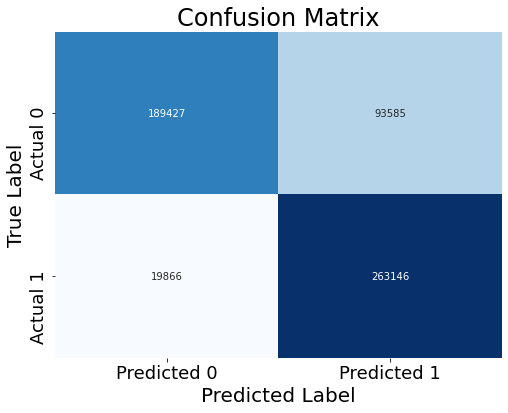

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define labels for the confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'], cbar=False)
plt.title('Confusion Matrix', fontsize=24)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

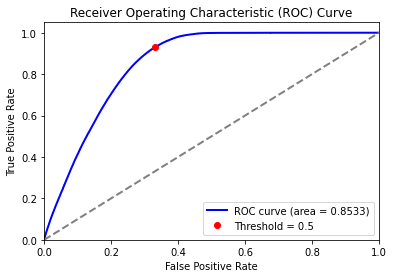

In [40]:
from sklearn.metrics import roc_curve, auc
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot the point at the default threshold of 0.5
default_threshold_index = np.where(thresholds > 0.5)[0][-1]
plt.plot(fpr[default_threshold_index], tpr[default_threshold_index], 'ro', label='Threshold = 0.5')
plt.legend(loc="lower right")

plt.show()

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4608      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

# Submission

In [42]:
test = pd.read_csv('/home/petewojtczak/Desktop/auto_insurance_clf/test.csv')

In [48]:
test.set_index('id', inplace=True)
test.drop(columns=['Driving_License'], inplace=True)
test.drop(columns=['Region_Code'], inplace=True)
test.drop(columns=['Policy_Sales_Channel'], inplace=True)

In [54]:
%%time
y_hat = model.predict(pd.DataFrame(prep.fit_transform(test)), verbose=0)

CPU times: user 4min 2s, sys: 10.7 s, total: 4min 13s
Wall time: 3min 25s


In [76]:
submission = pd.DataFrame(test.reset_index().id).assign(Response=y_hat)
submission

,id,Response
0,11504798,0.121
1,11504799,0.762
2,11504800,0.701
3,11504801,0.001
4,11504802,0.202
...,...,...
7669861,19174659,0.661
7669862,19174660,0.001
7669863,19174661,0.003
7669864,19174662,0.776


In [69]:
submission.to_csv('submission.csv', index=False)

In [ ]:
eval_df = y_test.assign(y_pred=y_pred, y_pred_binary=(y_pred >= 0.5).astype(int))

In [50]:
X_test

,Gender,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage
id,,,,,,,
1027097,Male,27,1,< 1 Year,No,24918.000,56
10566622,Male,47,0,1-2 Year,Yes,37181.000,40
1809555,Female,43,0,1-2 Year,Yes,35255.000,123
7162903,Male,22,0,< 1 Year,Yes,31517.000,256
2947126,Male,21,1,< 1 Year,No,34782.000,158
...,...,...,...,...,...,...,...
4187156,Female,38,0,1-2 Year,Yes,32929.000,232
8105028,Male,32,0,1-2 Year,Yes,2630.000,206
2020224,Female,24,0,< 1 Year,Yes,2630.000,241
